In [85]:
import os
import time
from datetime import datetime

import IPython
import IPython.display

import numpy as np
from math import *

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

import matplotlib.pyplot as plt
import pandas as pd
import random 

# Tensorflow

In [86]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
tf.test.is_built_with_cuda()

True

# Case 

In [87]:
folders = ['Rough','UTS','Elon']
index = 0
CASE = folders[index]

In [88]:
from prepross import importAndProcess
xtrain,xval,xtest,ytrain,yval,ytest = importAndProcess(index)
x = pd.concat((xtrain,xtest,xval),axis=0)
y = pd.concat((ytrain,ytest,yval),axis=0)

# Network

In [89]:
# Hyperparameters
lossfn = [tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanAbsolutePercentageError(),tf.keras.losses.MeanAbsoluteError()]
lossfn = lossfn[0]
optimizer = [tf.keras.optimizers.Adam(learning_rate=i,beta_1=0.09,beta_2=0.9) for i in [5e-2,1e-2,5e-3]]
optimizer = optimizer[index]
metrics = ['mean_squared_error','mean_absolute_error',tf.keras.losses.MeanAbsolutePercentageError()]

In [90]:
modelArchitecture = [[4,'tanh',1],[5,'relu',1],[1,'linear',1]]

In [91]:
#Give a random seed
tf.random.set_seed(random.randint(1,1000))
from networks import create_model

In [92]:
# Create a basic model Architecture
modelName = ''
for u,fn,b in modelArchitecture:
    modelName += str(u)+fn+str(b)+'_'
# Create Model
model = create_model(modelArchitecture,modelName,len(xtrain.columns))
# Display the model's architecture
model.summary()
model.compile(optimizer=optimizer,
                loss=lossfn, #tf.keras.losses.MSE
                metrics=metrics) #tf.keras.losses.Huber()


Model: "4tanh1_5relu1_1linear1_"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 4)                 32        
                                                                 
 dense_22 (Dense)            (None, 5)                 25        
                                                                 
 dense_23 (Dense)            (None, 1)                 6         
                                                                 
Total params: 63
Trainable params: 63
Non-trainable params: 0
_________________________________________________________________


In [93]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=100,
                                                    mode='min')
checkpoint = ModelCheckpoint('Rough/Roughmodel.h5', monitor='val_loss', verbose=0,
                                save_best_only=True, mode='min', save_weights_only=False)
callbacks = [early_stopping,checkpoint]

history = model.fit(xtrain,ytrain,verbose=0,epochs=3500,
                    validation_data=(xval,yval),
                    batch_size = 3,
                    callbacks=callbacks)  # ,tensorboard,checkpoint]))

val_performance = model.evaluate(xval,yval)
performance = model.evaluate(xtest,ytest, verbose=0)
# print(val_performance[modelName])
# print(performance[modelName])

1/1 [==============================] - 0s 22ms/step - loss: 1657.6053 - mean_squared_error: 1657.6053 - mean_absolute_error: 34.7437 - mean_absolute_percentage_error: 33.8540


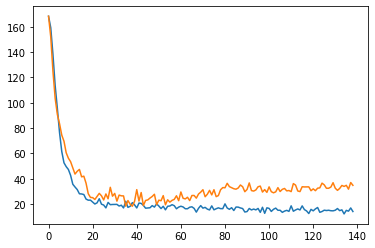

In [94]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
# plt.yscale('log')

1/1 [==============================] - 0s 24ms/step


Text(0, 0.5, 'Rough Prediction')

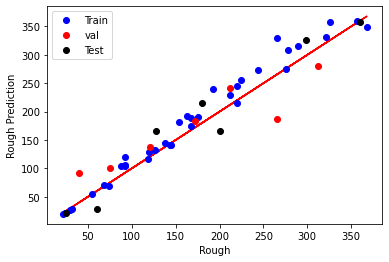

In [95]:
ypredtr =  model.predict(xtrain).squeeze()
ypredts = model.predict(xtest).squeeze()
ypredvl = model.predict(xval).squeeze()

y = [*ytrain,*ytest,*yval]
plt.plot(y,y,'r')
plt.plot(ytrain,ypredtr,'bo',label="Train")
plt.plot(yval,ypredvl,'ro',label="val")
plt.plot(ytest,ypredts,'ko',label = 'Test')
plt.legend()
plt.xlabel(CASE)
plt.ylabel(CASE +' Prediction')

In [96]:
print('Performance on validation Dataset:')
model.evaluate(xval,yval)
print('Performance on Test dataset:')
model.evaluate(xtest,ytest)
print('Performance on Train Dataset:')
model.evaluate(xtrain,ytrain)

2/2 [==============================] - 0s 4ms/step - loss: 450.6312 - mean_squared_error: 450.6312 - mean_absolute_error: 15.5484 - mean_absolute_percentage_error: 7.4511


[450.6312255859375, 450.6312255859375, 15.548392295837402, 7.451053619384766]